# LOSO MLP

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

2023-06-07 20:14:44.073817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 20:14:44.754582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Lists of Labels to be used for the Confusion Matrices

In [2]:
labels1 = ['Biking', 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
labels2 = ['Biking', 'Downstairs', 'Jogging', 'Standing_Sitting', 'Upstairs', 'Walking']

### Function to plot the Confusion Matrix

In [3]:
import itertools

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.set_ylim(-.5, float(len(classes))-0.5)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [4]:
from datetime import datetime

def perform_model(model, X_train, y_train, X_test, y_test, class_labels, num, callbacks, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Reds):
    
    
    # to store results at various phases
    results = dict()
    
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model for participant no.' +str(num)+ '..')
    model.fit(X_train, y_train, epochs=300, verbose=0, callbacks=[callbacks], validation_data=(X_test, y_test))
    
    
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    y_test_argmax = np.argmax(y_test, axis=1)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred_argmax
   

    # calculate overall accuracty of the model
    accuracy = accuracy_score(y_true=y_test_argmax, y_pred=y_pred_argmax)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = confusion_matrix(y_test_argmax, y_pred_argmax)
    results['confusion_matrix'] = cm
    if print_cm:
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible = False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    ax = plt.gca()
    ax.set_ylim(-.5,float(len(class_labels))-0.5)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    class_report = classification_report(y_test_argmax, y_pred_argmax)
    # store report in results
    results['classification_report'] = class_report
    print(class_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

### Function to print the Grid Search results

In [5]:
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    
    
    print('\n\t{}\n'.format(model.best_estimator_))
    best_estimator = model.best_estimator_


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    
    
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
    best_params = model.best_params_


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))
    
    return best_estimator, best_params

### Random MLP model function to be used as an instance in the grid search

We used different numbers for the hiddel layer neurons using the result $N_{h} = \frac{N_{s}}{\alpha\left(N_{in}+N_{out}\right)}$, where $\alpha \in [2,10]$, $N_{s}$ is the number of samples in training dataset, $N_{h}$ is the number of neurons in the hidden layer, $N_{in}$ is the number of neurons in the input layer and $N_{out}$ is the number of neurons in the output layer.

In [6]:
def keras_mlp(rate=0.1, momentum=0.0):
    model = Sequential()
    model.add(Dense(71, activation='relu', input_shape=(71,)))
    model.add(Dropout(rate=rate))
    model.add(Dense(7, activation='softmax'))
    
    optimizer = SGD(learning_rate=0.01, momentum=momentum)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Grid Search to find the optimal MLP model

In [7]:
def MLP_GRID():
    
    best_params = []
    
    for i in range(10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(i+1)+ '.csv').values
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(i+1)+ '.csv').values
        y_train = pd.read_csv('train_test_dataset/y_train_fold_' +str(i+1)+ '.csv').values.ravel()
        y_test = pd.read_csv('train_test_dataset/y_test_fold_' +str(i+1)+ '.csv').values.ravel()
        
        input_dim = X_train.shape[1]
        num_classes = np.unique(y_train).shape[0]

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        y_test_encoded = encoder.transform(y_test)
        
        param_grid = {'momentum': [0.7, 0.8, 0.9]}
    
        mlp_model = KerasClassifier(build_fn=keras_mlp, epochs=60, batch_size=32, verbose=0)
        mlp_model_grid = GridSearchCV(mlp_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
        mlp_model_grid.fit(X_train, y_train_encoded)
        
        optimal_estim, optimal_param = print_grid_search_attributes(mlp_model_grid)
    
        best_params.append(optimal_param)
    
    return best_params

In [8]:
#best_params = MLP_GRID()

In [9]:
#Function that finds the most common dictionary in a list
def most_common(List):
    dict_counts = Counter(tuple(d.items()) for d in List)
    most_common_dict = dict_counts.most_common(1)[0][0]
    return dict(most_common_dict)

In [10]:
best_params = [{'momentum': 0.9, 'rate': 0.2}]

### LOSO MLP function trained and tested using the optimal parameters found in the grid search

In [11]:
os.makedirs('LOSO_MLP/confusion_matrices', exist_ok=True)

def LOSO_MLP(parameters):
    
    best_params = most_common(parameters)
    
    early_stopping = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
    
    #lists to store the confusion matrix and accuracy for each participant
    cm_list = []
    acc_list = []
    
    #list to store the predicted values and the test values
    yTest = []
    yPred = []
    
    for i in range(10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(i+1)+ '.csv')
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(i+1)+ '.csv')
        y_train = pd.read_csv('train_test_dataset/y_train_fold_' +str(i+1)+ '.csv')
        y_test = pd.read_csv('train_test_dataset/y_test_fold_' +str(i+1)+ '.csv')
        input_dim = X_train.shape[1]
        num_classes = np.unique(y_train).shape[0]

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        encoder = LabelEncoder()
        y_train = encoder.fit_transform(y_train)
        y_test = encoder.transform(y_test)

        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)
    
        y_test_argmax = np.argmax(y_test_categorical, axis=1)
        
        model = Sequential()
        model.add(Dense(71, activation='relu', input_shape=(input_dim,)))
        model.add(Dropout(best_params['rate']))
        model.add(Dense(num_classes, activation='softmax'))
    
        optimizer = SGD(learning_rate=0.01, momentum=best_params['momentum'])
    
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        model_results = perform_model(model, X_train, y_train_categorical, X_test, y_test_categorical,\
                                     class_labels=labels1, num=i+1, callbacks=early_stopping)
        y_pred = model_results['predicted']
        
        yTest.extend(y_test_argmax)
        yPred.extend(y_pred)
        
        cm = model_results['confusion_matrix']
        np.savetxt('LOSO_MLP/confusion_matrices/cm_' +str(i+1)+ '.csv', cm, delimiter=',')
        acc = model_results['accuracy']
        
        cm_list.append(cm)
        acc_list.append(acc)
        
    return cm_list, yTest, yPred

/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
2023-06-07 20:14:45.896201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 20:14:45.931514: W tensorflow/core/common_runtime/gpu/gpu_device.c

training the model for participant no.1..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:14.556044


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.207414


---------------------
|      Accuracy      |
---------------------

    0.9055555555555556


--------------------
| Confusion Matrix |
--------------------

 [[164   0   0  16   0   0   0]
 [  0 189   0   0   0   0   0]
 [  0   0 180   0   0   0   0]
 [  0   1   3 176   0   0   0]
 [  0   0   4  77  96   0   3]
 [  2  13   0   0   0 165   0]
 [  0   0   0   0   0   0 171]]


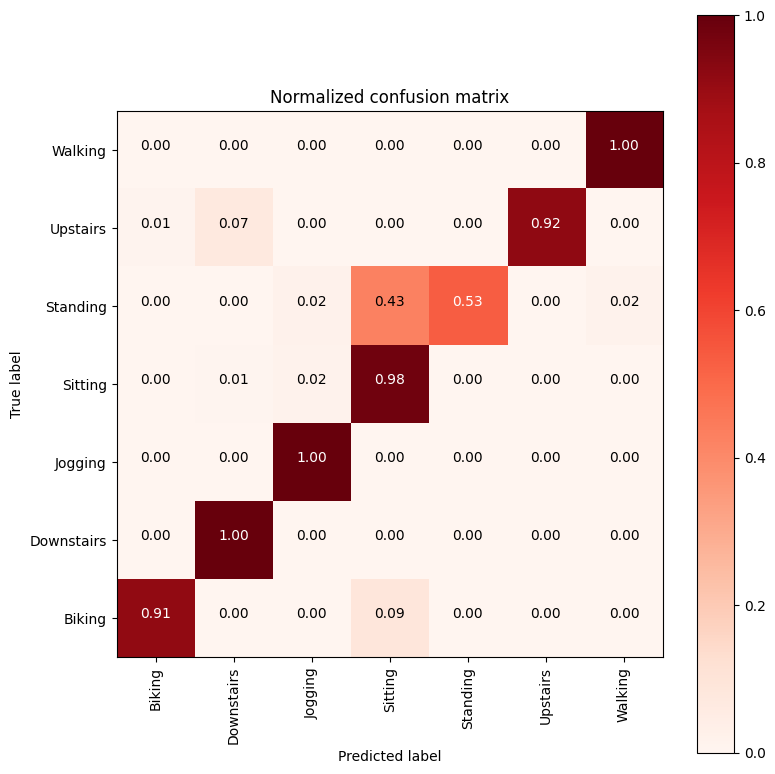

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       180
           1       0.93      1.00      0.96       189
           2       0.96      1.00      0.98       180
           3       0.65      0.98      0.78       180
           4       1.00      0.53      0.70       180
           5       1.00      0.92      0.96       180
           6       0.98      1.00      0.99       171

    accuracy                           0.91      1260
   macro avg       0.93      0.91      0.90      1260
weighted avg       0.93      0.91      0.90      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.2..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:35.347327


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.147762


---------------------
|      Accuracy      |
---------------------

    0.9753968253968254


--------------------
| Confusion Matrix |
--------------------

 [[179   0   0   0   0   1   0]
 [  0 184   0   0   0   0   5]
 [  0   0 179   0   1   0   0]
 [  2   0   0 172   6   0   0]
 [  0   0   1   2 177   0   0]
 [  0  11   0   0   0 169   0]
 [  0   0   0   0   2   0 169]]


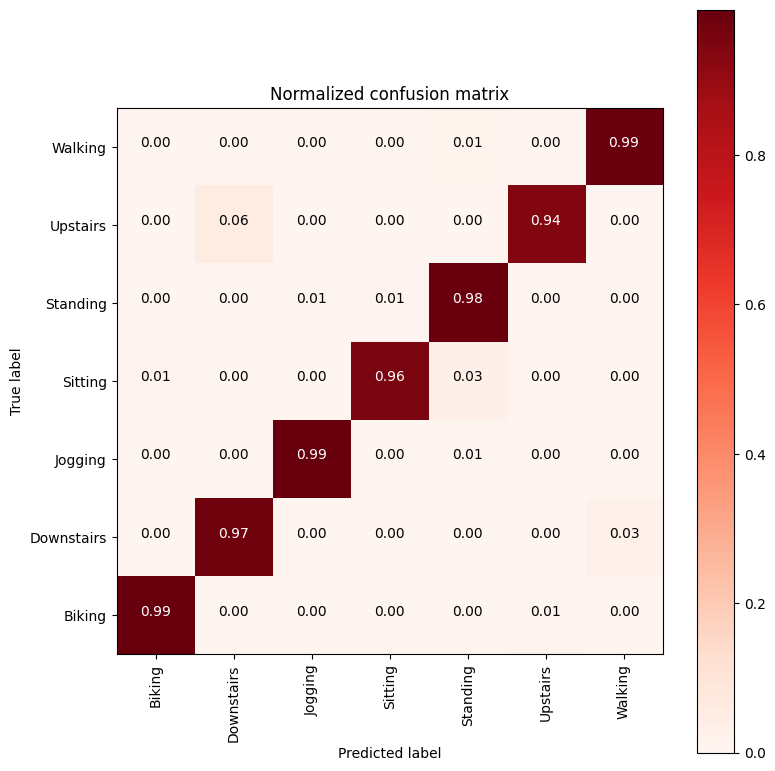

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       180
           1       0.94      0.97      0.96       189
           2       0.99      0.99      0.99       180
           3       0.99      0.96      0.97       180
           4       0.95      0.98      0.97       180
           5       0.99      0.94      0.97       180
           6       0.97      0.99      0.98       171

    accuracy                           0.98      1260
   macro avg       0.98      0.98      0.98      1260
weighted avg       0.98      0.98      0.98      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.3..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:32.980611


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.148436


---------------------
|      Accuracy      |
---------------------

    0.9571428571428572


--------------------
| Confusion Matrix |
--------------------

 [[165   0   0   0   0  15   0]
 [  0 188   0   0   0   1   0]
 [  0   0 180   0   0   0   0]
 [  5   1   1 171   2   0   0]
 [  0   0   1  12 167   0   0]
 [ 14   1   0   0   0 165   0]
 [  0   0   0   0   1   0 170]]


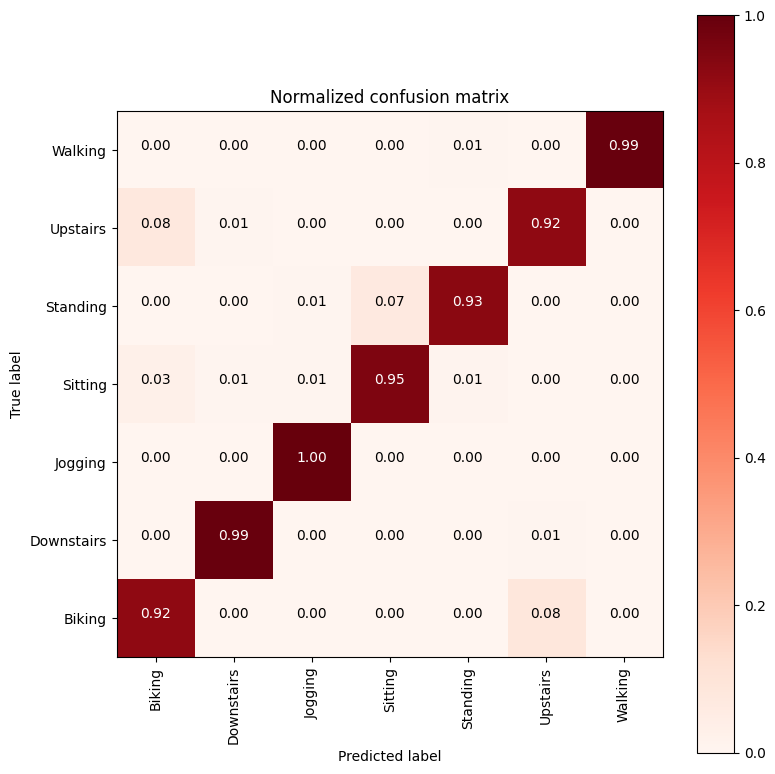

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       180
           1       0.99      0.99      0.99       189
           2       0.99      1.00      0.99       180
           3       0.93      0.95      0.94       180
           4       0.98      0.93      0.95       180
           5       0.91      0.92      0.91       180
           6       1.00      0.99      1.00       171

    accuracy                           0.96      1260
   macro avg       0.96      0.96      0.96      1260
weighted avg       0.96      0.96      0.96      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.4..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:33.212032


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.154278


---------------------
|      Accuracy      |
---------------------

    0.7261904761904762


--------------------
| Confusion Matrix |
--------------------

 [[179   0   0   0   0   1   0]
 [  0 188   0   0   0   1   0]
 [  0   0 178   1   1   0   0]
 [  1   0   0 170   9   0   0]
 [  0   4   1 166   9   0   0]
 [  0   0   0   0   0 180   0]
 [  0 160   0   0   0   0  11]]


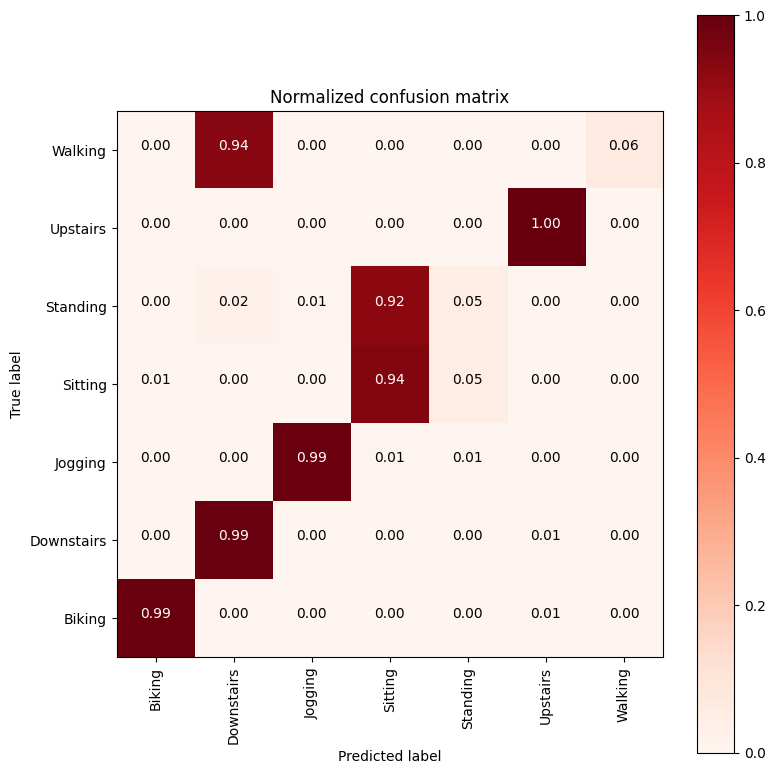

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       180
           1       0.53      0.99      0.70       189
           2       0.99      0.99      0.99       180
           3       0.50      0.94      0.66       180
           4       0.47      0.05      0.09       180
           5       0.99      1.00      0.99       180
           6       1.00      0.06      0.12       171

    accuracy                           0.73      1260
   macro avg       0.78      0.72      0.65      1260
weighted avg       0.78      0.73      0.65      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.5..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:33.321778


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.150414


---------------------
|      Accuracy      |
---------------------

    0.8634920634920635


--------------------
| Confusion Matrix |
--------------------

 [[175   0   0   5   0   0   0]
 [  0 189   0   0   0   0   0]
 [  0   0 180   0   0   0   0]
 [  0   0   0 180   0   0   0]
 [  0   0   1 162  17   0   0]
 [  0   3   0   0   0 177   0]
 [  0   0   0   0   1   0 170]]


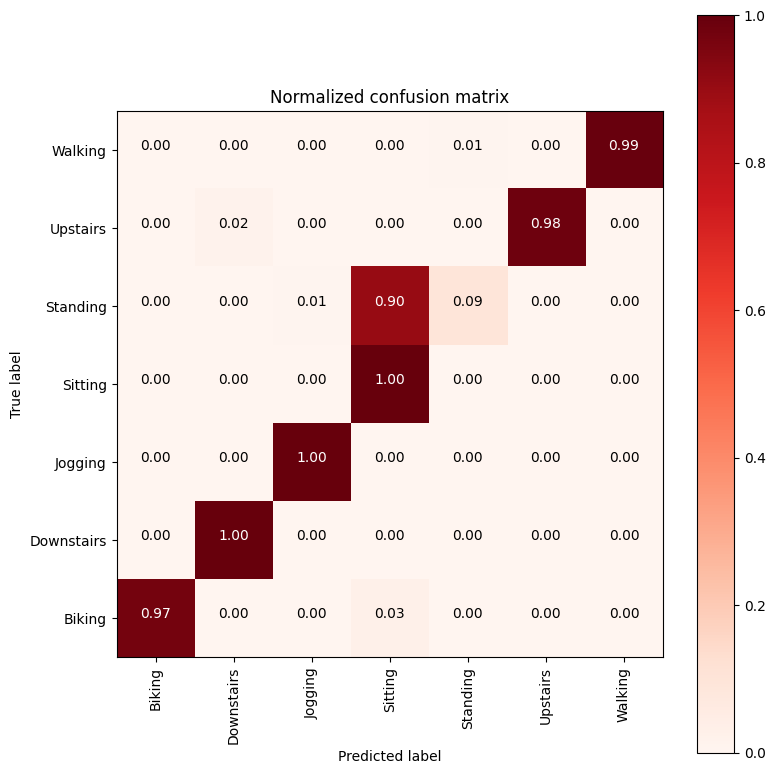

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       180
           1       0.98      1.00      0.99       189
           2       0.99      1.00      1.00       180
           3       0.52      1.00      0.68       180
           4       0.94      0.09      0.17       180
           5       1.00      0.98      0.99       180
           6       1.00      0.99      1.00       171

    accuracy                           0.86      1260
   macro avg       0.92      0.86      0.83      1260
weighted avg       0.92      0.86      0.83      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.6..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:32.869613


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.148820


---------------------
|      Accuracy      |
---------------------

    0.9111111111111111


--------------------
| Confusion Matrix |
--------------------

 [[174   0   0   0   0   6   0]
 [  0 187   0   0   0   2   0]
 [  0  25 154   0   1   0   0]
 [  6   0   0 165   9   0   0]
 [  0   0   0  17 161   0   2]
 [  0   0   0   0   0 180   0]
 [  0  44   0   0   0   0 127]]


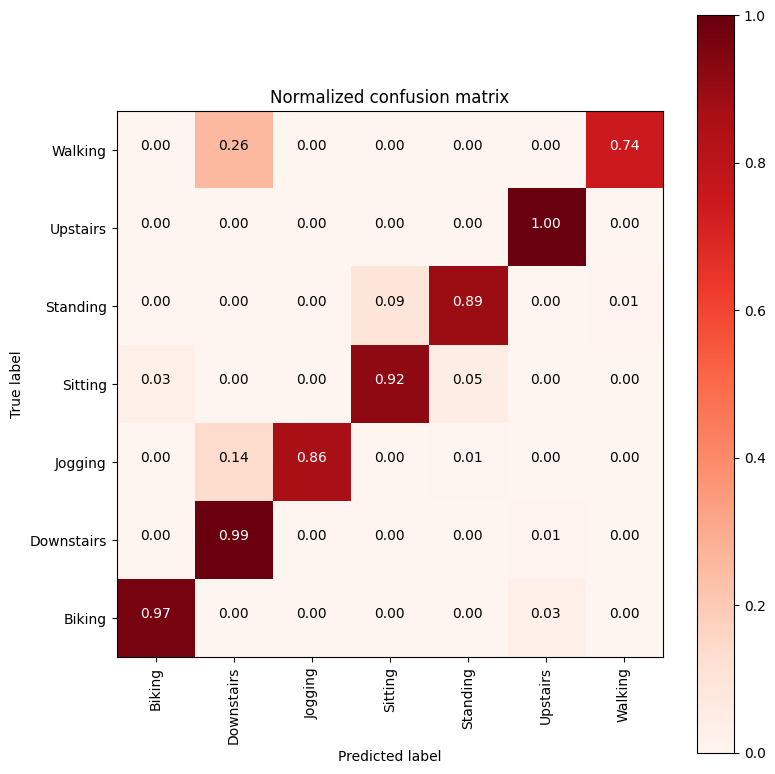

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       180
           1       0.73      0.99      0.84       189
           2       1.00      0.86      0.92       180
           3       0.91      0.92      0.91       180
           4       0.94      0.89      0.92       180
           5       0.96      1.00      0.98       180
           6       0.98      0.74      0.85       171

    accuracy                           0.91      1260
   macro avg       0.93      0.91      0.91      1260
weighted avg       0.92      0.91      0.91      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.7..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:33.290519


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.151895


---------------------
|      Accuracy      |
---------------------

    0.7182539682539683


--------------------
| Confusion Matrix |
--------------------

 [[176   0   0   2   0   2   0]
 [  0 187   0   0   0   2   0]
 [  0   1 175   0   4   0   0]
 [  0   0   0   6 174   0   0]
 [  1   3   1 161  12   2   0]
 [  0   0   0   0   0 180   0]
 [  0   0   0   0   2   0 169]]


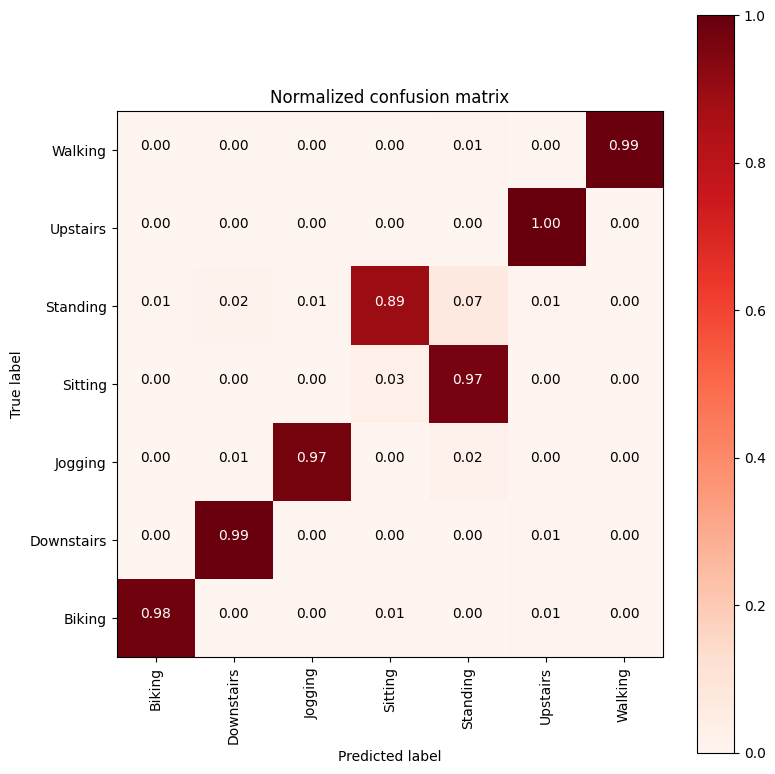

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       180
           1       0.98      0.99      0.98       189
           2       0.99      0.97      0.98       180
           3       0.04      0.03      0.03       180
           4       0.06      0.07      0.06       180
           5       0.97      1.00      0.98       180
           6       1.00      0.99      0.99       171

    accuracy                           0.72      1260
   macro avg       0.72      0.72      0.72      1260
weighted avg       0.72      0.72      0.72      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.8..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:24.550200


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.151989


---------------------
|      Accuracy      |
---------------------

    0.7738095238095238


--------------------
| Confusion Matrix |
--------------------

 [[180   0   0   0   0   0   0]
 [  0 189   0   0   0   0   0]
 [  0   0 180   0   0   0   0]
 [  7   0   0   8 165   0   0]
 [  0   0   1 106  73   0   0]
 [  5   0   0   0   0 175   0]
 [  0   0   0   0   1   0 170]]


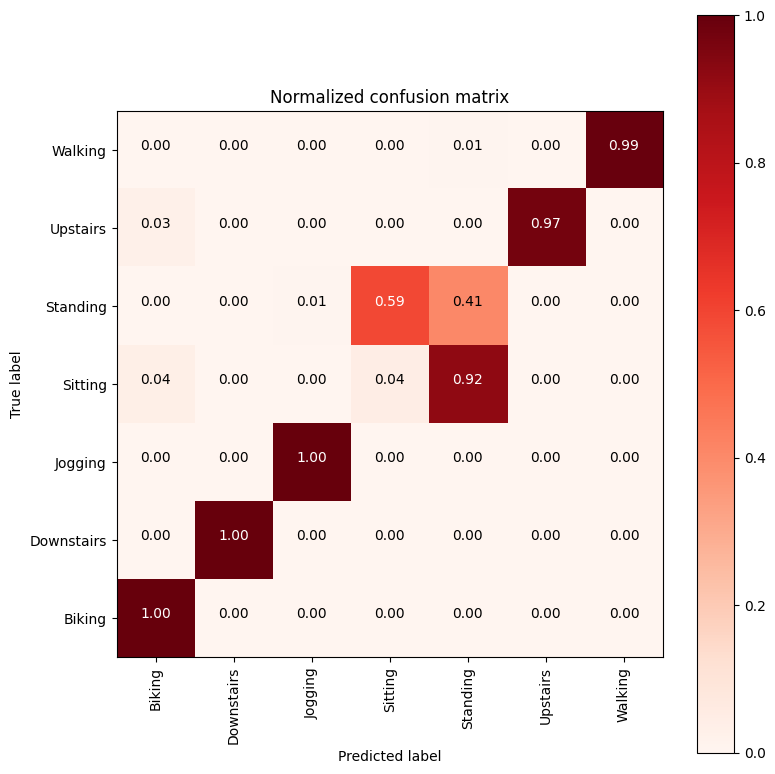

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       180
           1       1.00      1.00      1.00       189
           2       0.99      1.00      1.00       180
           3       0.07      0.04      0.05       180
           4       0.31      0.41      0.35       180
           5       1.00      0.97      0.99       180
           6       1.00      0.99      1.00       171

    accuracy                           0.77      1260
   macro avg       0.76      0.77      0.76      1260
weighted avg       0.76      0.77      0.76      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.9..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:33.082944


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.156589


---------------------
|      Accuracy      |
---------------------

    0.8214285714285714


--------------------
| Confusion Matrix |
--------------------

 [[139   0   0  40   0   1   0]
 [  0 181   0   0   6   2   0]
 [  0   0 180   0   0   0   0]
 [  0   0   1  14 165   0   0]
 [  0   0   1   6 173   0   0]
 [  2   0   0   0   0 178   0]
 [  0   0   0   0   1   0 170]]


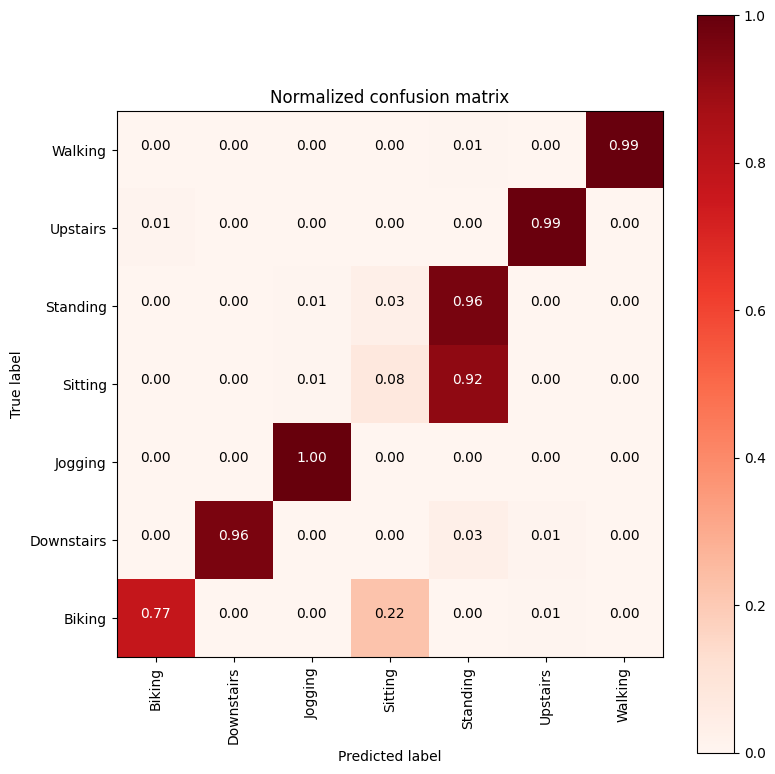

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       180
           1       1.00      0.96      0.98       189
           2       0.99      1.00      0.99       180
           3       0.23      0.08      0.12       180
           4       0.50      0.96      0.66       180
           5       0.98      0.99      0.99       180
           6       1.00      0.99      1.00       171

    accuracy                           0.82      1260
   macro avg       0.81      0.82      0.80      1260
weighted avg       0.81      0.82      0.80      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.10..
Done 
 

training_time(HH:MM:SS.ms) - 0:01:33.116821


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.152269


---------------------
|      Accuracy      |
---------------------

    0.7484126984126984


--------------------
| Confusion Matrix |
--------------------

 [[179   0   0   0   0   1   0]
 [  0 188   0   0   0   1   0]
 [  0   0 176   0   4   0   0]
 [  7   0   0 166   7   0   0]
 [  0   3   0 123  54   0   0]
 [  0   0   0   0   0 180   0]
 [  0 171   0   0   0   0   0]]


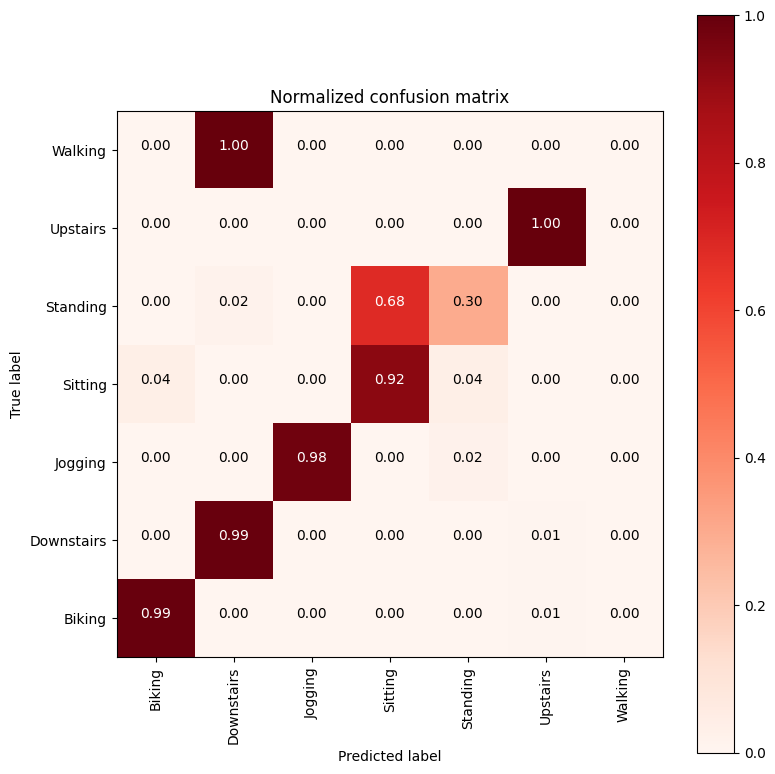

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       180
           1       0.52      0.99      0.68       189
           2       1.00      0.98      0.99       180
           3       0.57      0.92      0.71       180
           4       0.83      0.30      0.44       180
           5       0.99      1.00      0.99       180
           6       0.00      0.00      0.00       171

    accuracy                           0.75      1260
   macro avg       0.70      0.74      0.68      1260
weighted avg       0.70      0.75      0.69      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
cm, yTest, yPred = LOSO_MLP(best_params)

### Method to save the y_test and y_pred results

Run the following code snippet if you wish to run the whole file

In [13]:
#os.makedirs('LOSO_MLP/test_y_pred', exist_ok=True)
#
#with open('LOSO_MLP/test_y_pred/yTest.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    
#    for item in yTest:
#        writer.writerow([item])
#        
#with open('LOSO_MLP/test_y_pred/yPred.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    
#    for item in yPred:
#        writer.writerow([item])

### Method for loading yTest_regrouped and yPred_regrouped

In [14]:
#yTest=[]
#with open('LOSO_SVM/test_y_pred/yTest.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yTest.append(row[0])
#
#yPred=[]
#with open('LOSO_SVM/test_y_pred/yPred.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yPred.append(row[0])

### Method to print the Confusion Matrix of all participants

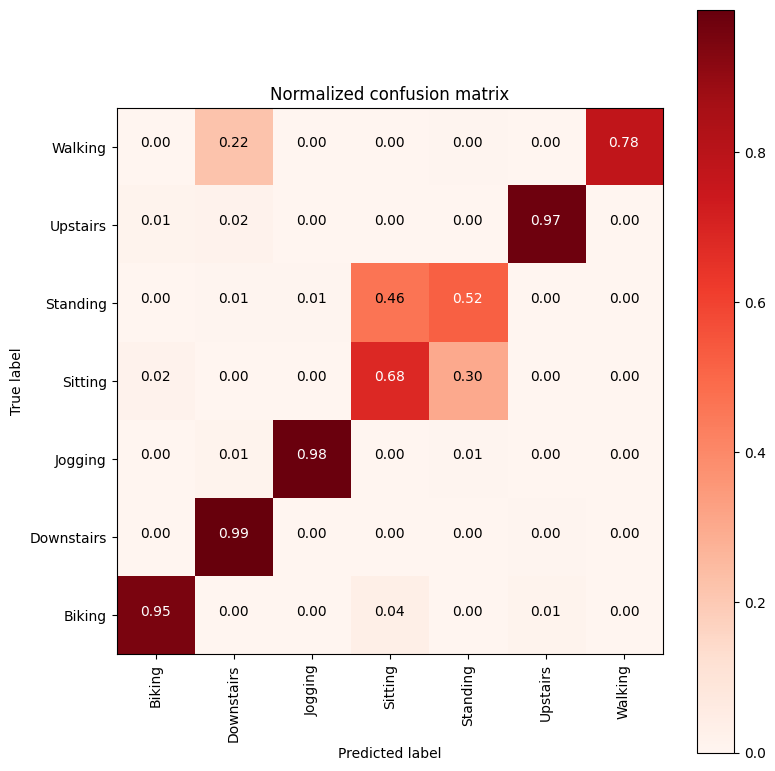

In [15]:
complete_conf_matrix = cm[0] + cm[1] + cm[2] + cm[3] + cm[4] + cm[5] + cm[6] + cm[7] + cm[8] + cm[9]

#cm_list = []
#for i in range(10):
#    cm = np.loadtxt('LOSO_MLP/confusion_matrices/cm_' +str(i+1)+ '.csv', delimiter=',').astype(np.int64)
#    cm_list.append(cm)
    
#complete_conf_matrix = np.sum(cm_list, axis=0)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(complete_conf_matrix, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

### Code snippet to print the middle accuracy

In [16]:
print('-------------------')
print('| Middle Accuracy |')
print('-------------------')
middle_acc = complete_conf_matrix.diagonal() / complete_conf_matrix.sum(axis = 1)
print(middle_acc)

-------------------
| Middle Accuracy |
-------------------
[0.95       0.98941799 0.97888889 0.68222222 0.52166667 0.97166667
 0.77602339]


### Code snippet to print the Classification Report for all participans

In [17]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr = classification_report(yTest, yPred, target_names=labels1)
print(cr)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
              precision    recall  f1-score   support

      Biking       0.97      0.95      0.96      1800
  Downstairs       0.81      0.99      0.89      1890
     Jogging       0.99      0.98      0.98      1800
     Sitting       0.58      0.68      0.63      1800
    Standing       0.63      0.52      0.57      1800
    Upstairs       0.98      0.97      0.98      1800
     Walking       0.99      0.78      0.87      1710

    accuracy                           0.84     12600
   macro avg       0.85      0.84      0.84     12600
weighted avg       0.85      0.84      0.84     12600



### Code snippet to print the accuracy for alla participants

In [18]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(yTest, yPred)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.8400793650793651



### LOSO MLP model of the regrouped dataset

The parameters that are used to train and test the classifier are the optimal parameters that are found in the grid search above. After noticing that the algorithm confuses the 'walking' and 'standing' classes we joined those classes and performed LOSO Cross Validation to the regrouped dataset.

In [19]:
os.makedirs('LOSO_MLP/regrouped_confusion_matrices', exist_ok=True)

def LOSO_MLP_REGROUPED(parameters):
    
    best_params = most_common(parameters)
    
    early_stopping = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
    
    #lists to store the confusion matrix and accuracy for each participant
    cm_list = []
    acc_list = []
    
    #list to store the predicted values and the test values
    yTest = []
    yPred = []
    
    #in the second 'for' loop we train the model with the optimal parameters
    for i in range(10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(i+1)+ '.csv')
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(i+1)+ '.csv')
        y_train = pd.read_csv('regrouped_dataset/y_train_' +str(i+1)+ '_regrouped.csv')
        y_test = pd.read_csv('regrouped_dataset/y_test_' +str(i+1)+ '_regrouped.csv')
        input_dim = X_train.shape[1]
        num_classes = np.unique(y_train).shape[0]

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        encoder = LabelEncoder()
        y_train = encoder.fit_transform(y_train)
        y_test = encoder.transform(y_test)

        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)
    
        y_test_argmax = np.argmax(y_test_categorical, axis=1)
        
        model = Sequential()
        model.add(Dense(30, activation='relu', input_shape=(input_dim,)))
        model.add(Dropout(best_params['rate']))
        model.add(Dense(num_classes, activation='softmax'))
    
        optimizer = SGD(learning_rate=0.01, momentum=best_params['momentum'])
    
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        model_results = perform_model(model, X_train, y_train_categorical, X_test, y_test_categorical,\
                                     class_labels=labels1, num=i+1, callbacks=early_stopping)
        y_pred = model_results['predicted']
        
        yTest.extend(y_test_argmax)
        yPred.extend(y_pred)
        
        cm = model_results['confusion_matrix']
        np.savetxt('LOSO_MLP/regrouped_confusion_matrices/cm_' +str(i+1)+ '_regrouped.csv', cm, delimiter=',')
        acc = model_results['accuracy']
        
        cm_list.append(cm)
        acc_list.append(acc)
        
    return cm_list, yTest, yPred

/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.1..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:26.093259


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.151114


---------------------
|      Accuracy      |
---------------------

    0.9634920634920635


--------------------
| Confusion Matrix |
--------------------

 [[166   0   0  14   0   0]
 [  0 186   0   0   0   3]
 [  0   0 180   0   0   0]
 [  0   0   8 350   0   2]
 [  3  16   0   0 161   0]
 [  0   0   0   0   0 171]]


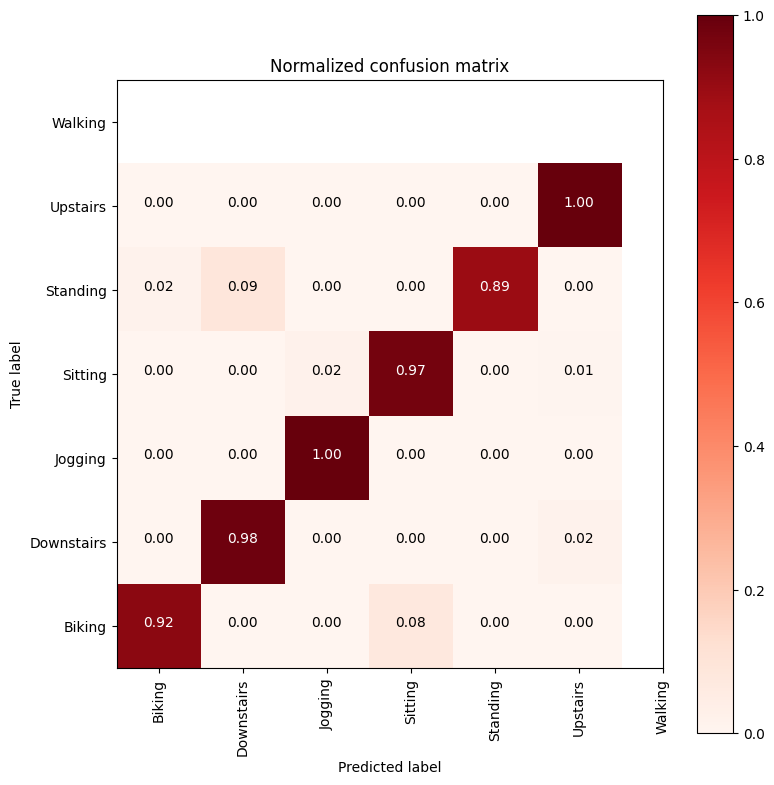

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       180
           1       0.92      0.98      0.95       189
           2       0.96      1.00      0.98       180
           3       0.96      0.97      0.97       360
           4       1.00      0.89      0.94       180
           5       0.97      1.00      0.99       171

    accuracy                           0.96      1260
   macro avg       0.97      0.96      0.96      1260
weighted avg       0.96      0.96      0.96      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.2..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:27.808246


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.148258


---------------------
|      Accuracy      |
---------------------

    0.9841269841269841


--------------------
| Confusion Matrix |
--------------------

 [[178   0   0   0   2   0]
 [  0 186   0   0   0   3]
 [  0   0 179   1   0   0]
 [  2   0   1 357   0   0]
 [  0  10   0   0 170   0]
 [  0   0   0   1   0 170]]


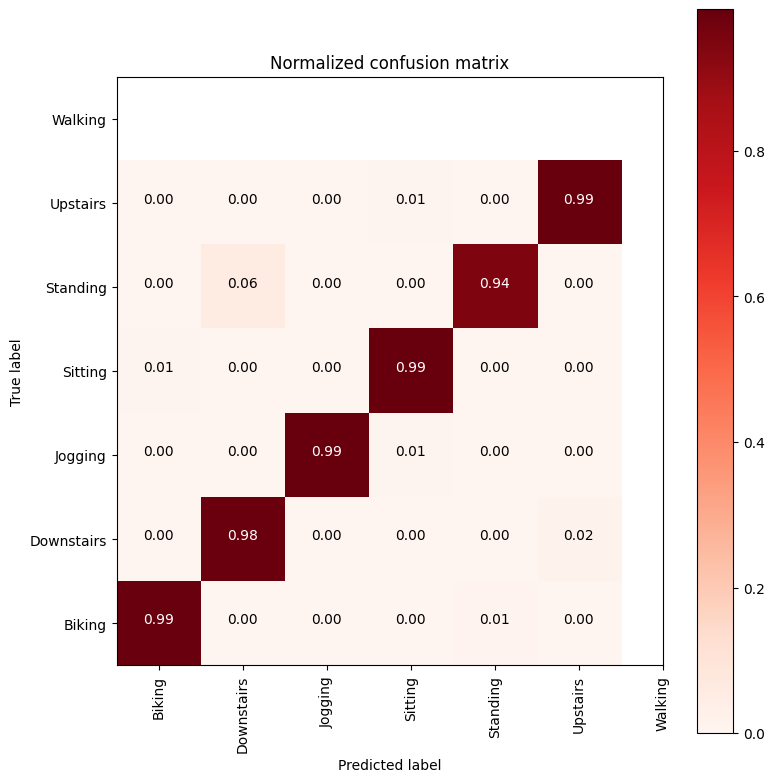

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       180
           1       0.95      0.98      0.97       189
           2       0.99      0.99      0.99       180
           3       0.99      0.99      0.99       360
           4       0.99      0.94      0.97       180
           5       0.98      0.99      0.99       171

    accuracy                           0.98      1260
   macro avg       0.98      0.98      0.98      1260
weighted avg       0.98      0.98      0.98      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.3..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:39.210331


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.149932


---------------------
|      Accuracy      |
---------------------

    0.9634920634920635


--------------------
| Confusion Matrix |
--------------------

 [[175   0   0   0   5   0]
 [  0 183   0   0   6   0]
 [  0   0 179   1   0   0]
 [  6   0   1 353   0   0]
 [ 25   1   0   0 154   0]
 [  0   0   0   1   0 170]]


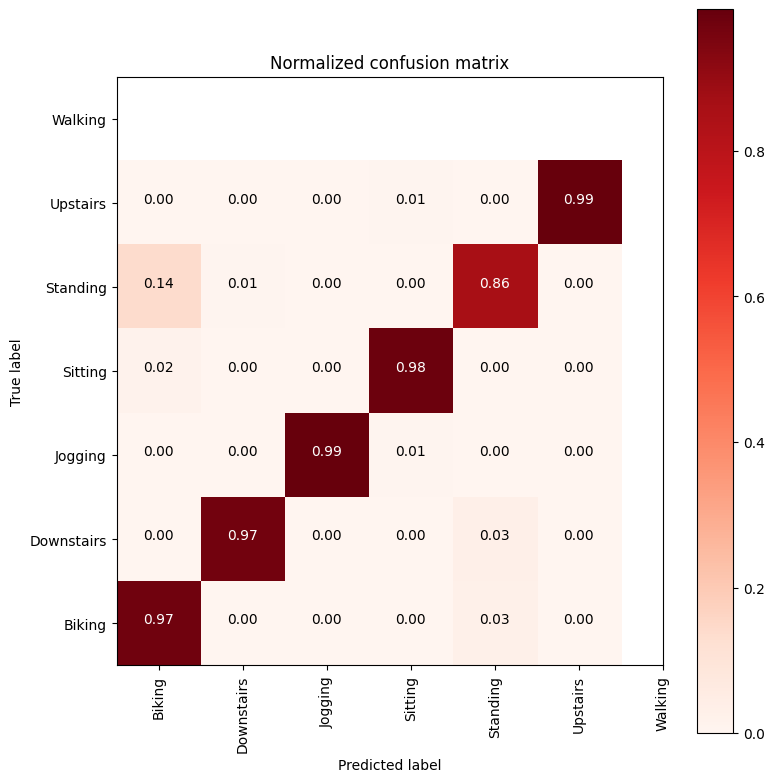

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       180
           1       0.99      0.97      0.98       189
           2       0.99      0.99      0.99       180
           3       0.99      0.98      0.99       360
           4       0.93      0.86      0.89       180
           5       1.00      0.99      1.00       171

    accuracy                           0.96      1260
   macro avg       0.96      0.96      0.96      1260
weighted avg       0.97      0.96      0.96      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.4..
Done 
 

training_time(HH:MM:SS.ms) - 0:01:33.978622


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.158434


---------------------
|      Accuracy      |
---------------------

    0.8603174603174604


--------------------
| Confusion Matrix |
--------------------

 [[179   0   0   0   1   0]
 [  0 188   0   0   1   0]
 [  0   0 179   1   0   0]
 [  2   3   2 353   0   0]
 [  0   0   0   0 180   0]
 [  0 166   0   0   0   5]]


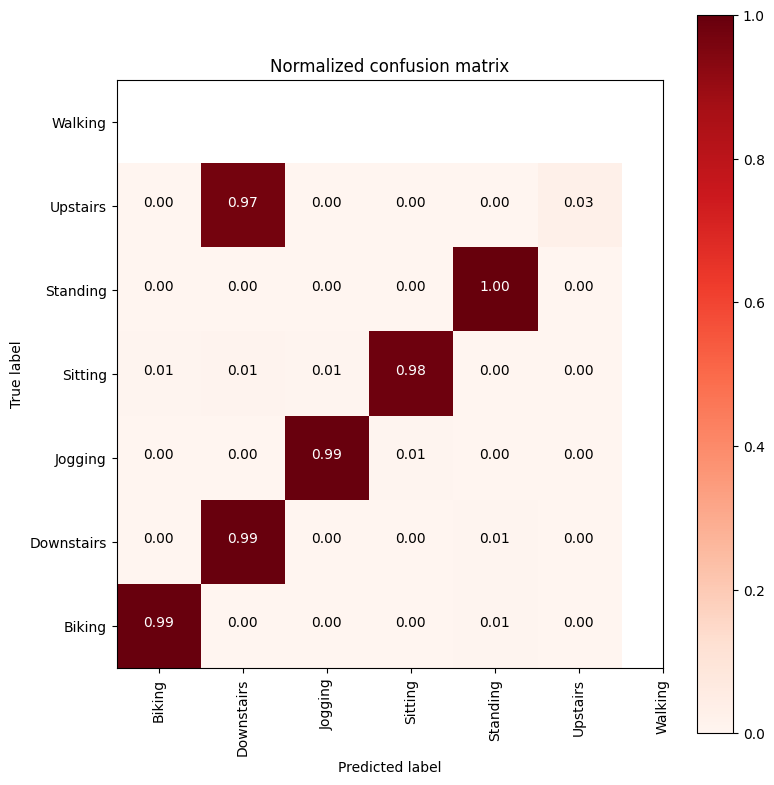

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       180
           1       0.53      0.99      0.69       189
           2       0.99      0.99      0.99       180
           3       1.00      0.98      0.99       360
           4       0.99      1.00      0.99       180
           5       1.00      0.03      0.06       171

    accuracy                           0.86      1260
   macro avg       0.92      0.83      0.79      1260
weighted avg       0.92      0.86      0.82      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.5..
Done 
 

training_time(HH:MM:SS.ms) - 0:01:50.367460


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.156035


---------------------
|      Accuracy      |
---------------------

    0.9904761904761905


--------------------
| Confusion Matrix |
--------------------

 [[175   0   0   3   2   0]
 [  0 189   0   0   0   0]
 [  0   0 177   3   0   0]
 [  0   0   2 358   0   0]
 [  0   1   0   0 179   0]
 [  0   0   0   1   0 170]]


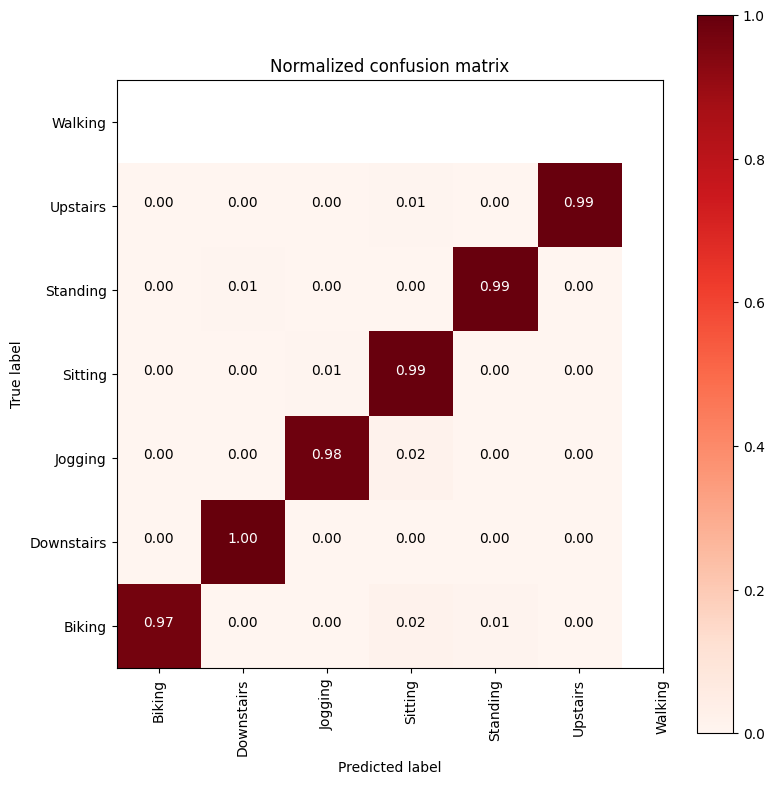

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       180
           1       0.99      1.00      1.00       189
           2       0.99      0.98      0.99       180
           3       0.98      0.99      0.99       360
           4       0.99      0.99      0.99       180
           5       1.00      0.99      1.00       171

    accuracy                           0.99      1260
   macro avg       0.99      0.99      0.99      1260
weighted avg       0.99      0.99      0.99      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.6..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:12.851161


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.151027


---------------------
|      Accuracy      |
---------------------

    0.9119047619047619


--------------------
| Confusion Matrix |
--------------------

 [[175   0   0   0   5   0]
 [  0 187   0   0   2   0]
 [  0  58 120   2   0   0]
 [  6   0   0 352   0   2]
 [  0   0   0   0 180   0]
 [  0  36   0   0   0 135]]


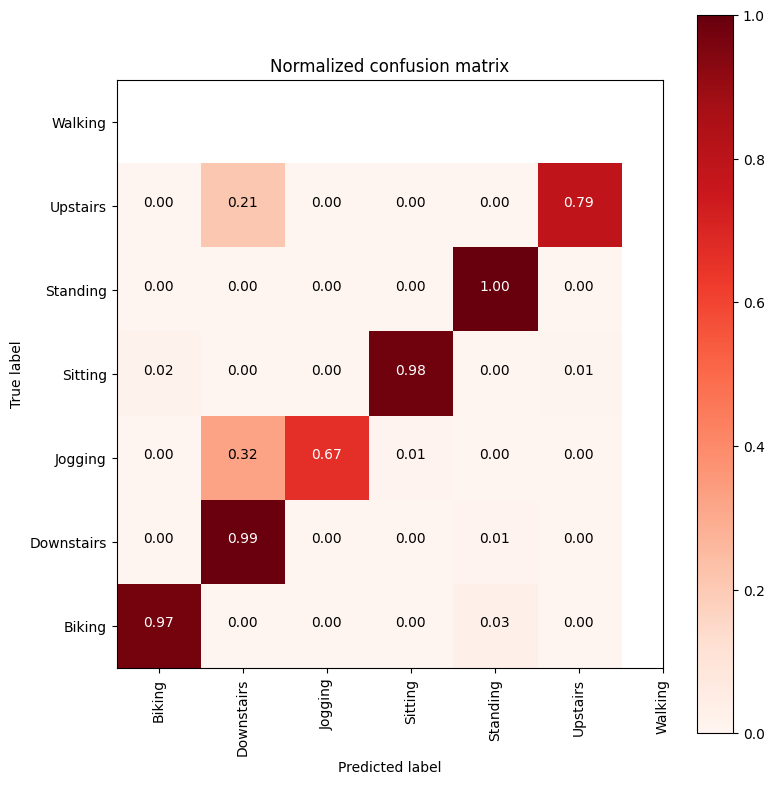

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       180
           1       0.67      0.99      0.80       189
           2       1.00      0.67      0.80       180
           3       0.99      0.98      0.99       360
           4       0.96      1.00      0.98       180
           5       0.99      0.79      0.88       171

    accuracy                           0.91      1260
   macro avg       0.93      0.90      0.90      1260
weighted avg       0.94      0.91      0.91      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.7..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:24.917658


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.152471


---------------------
|      Accuracy      |
---------------------

    0.9658730158730159


--------------------
| Confusion Matrix |
--------------------

 [[177   0   0   1   2   0]
 [  0 187   0   0   2   0]
 [  0  27 151   2   0   0]
 [  2   6   0 352   0   0]
 [  0   0   0   0 180   0]
 [  0   0   0   1   0 170]]


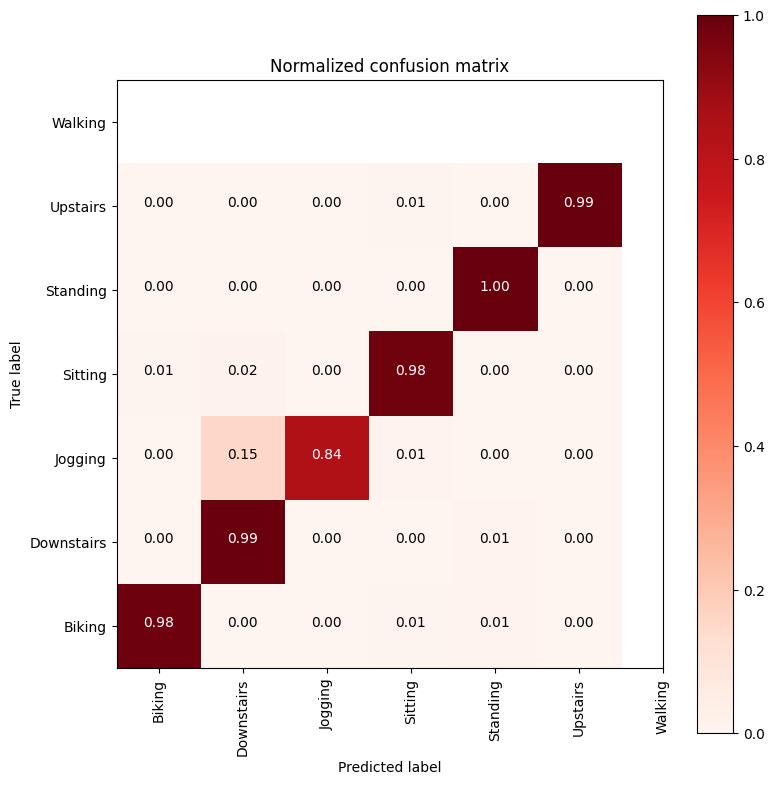

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       180
           1       0.85      0.99      0.91       189
           2       1.00      0.84      0.91       180
           3       0.99      0.98      0.98       360
           4       0.98      1.00      0.99       180
           5       1.00      0.99      1.00       171

    accuracy                           0.97      1260
   macro avg       0.97      0.96      0.96      1260
weighted avg       0.97      0.97      0.97      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.8..
Done 
 

training_time(HH:MM:SS.ms) - 0:02:00.228228


Predicting test data
40/40 [==============================] - 0s 960us/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.132778


---------------------
|      Accuracy      |
---------------------

    0.9896825396825397


--------------------
| Confusion Matrix |
--------------------

 [[180   0   0   0   0   0]
 [  0 189   0   0   0   0]
 [  0   0 180   0   0   0]
 [  6   0   3 351   0   0]
 [  4   0   0   0 176   0]
 [  0   0   0   0   0 171]]


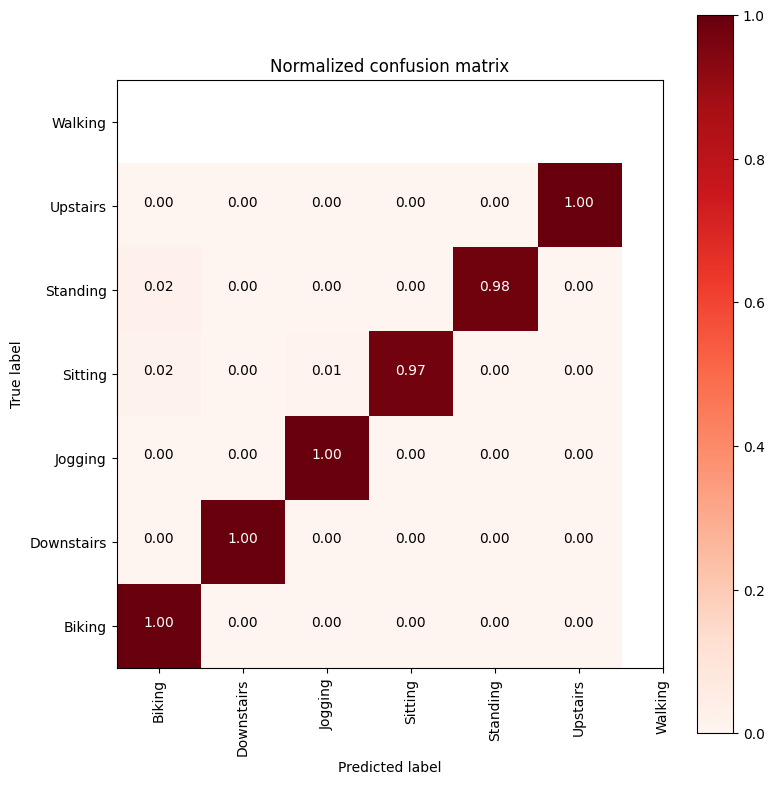

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       180
           1       1.00      1.00      1.00       189
           2       0.98      1.00      0.99       180
           3       1.00      0.97      0.99       360
           4       1.00      0.98      0.99       180
           5       1.00      1.00      1.00       171

    accuracy                           0.99      1260
   macro avg       0.99      0.99      0.99      1260
weighted avg       0.99      0.99      0.99      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.9..
Done 
 

training_time(HH:MM:SS.ms) - 0:01:26.843901


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.153537


---------------------
|      Accuracy      |
---------------------

    0.9682539682539683


--------------------
| Confusion Matrix |
--------------------

 [[172   0   0   8   0   0]
 [  0 166   0  23   0   0]
 [  0   0 180   0   0   0]
 [  0   0   4 356   0   0]
 [  3   1   0   0 176   0]
 [  0   0   0   1   0 170]]


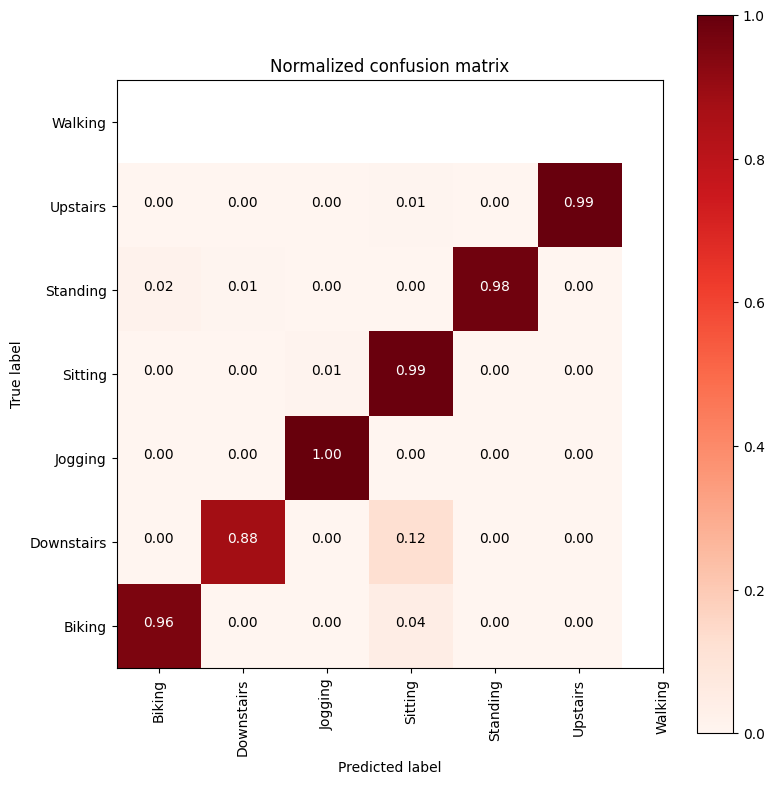

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       180
           1       0.99      0.88      0.93       189
           2       0.98      1.00      0.99       180
           3       0.92      0.99      0.95       360
           4       1.00      0.98      0.99       180
           5       1.00      0.99      1.00       171

    accuracy                           0.97      1260
   macro avg       0.98      0.97      0.97      1260
weighted avg       0.97      0.97      0.97      1260



/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training the model for participant no.10..
Done 
 

training_time(HH:MM:SS.ms) - 0:01:40.073620


Predicting test data
40/40 [==============================] - 0s 1ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.152848


---------------------
|      Accuracy      |
---------------------

    0.8539682539682539


--------------------
| Confusion Matrix |
--------------------

 [[180   0   0   0   0   0]
 [  0 188   0   0   1   0]
 [  0   0 175   5   0   0]
 [  7   2   0 351   0   0]
 [  0   0   0   0 180   0]
 [  0 169   0   0   0   2]]


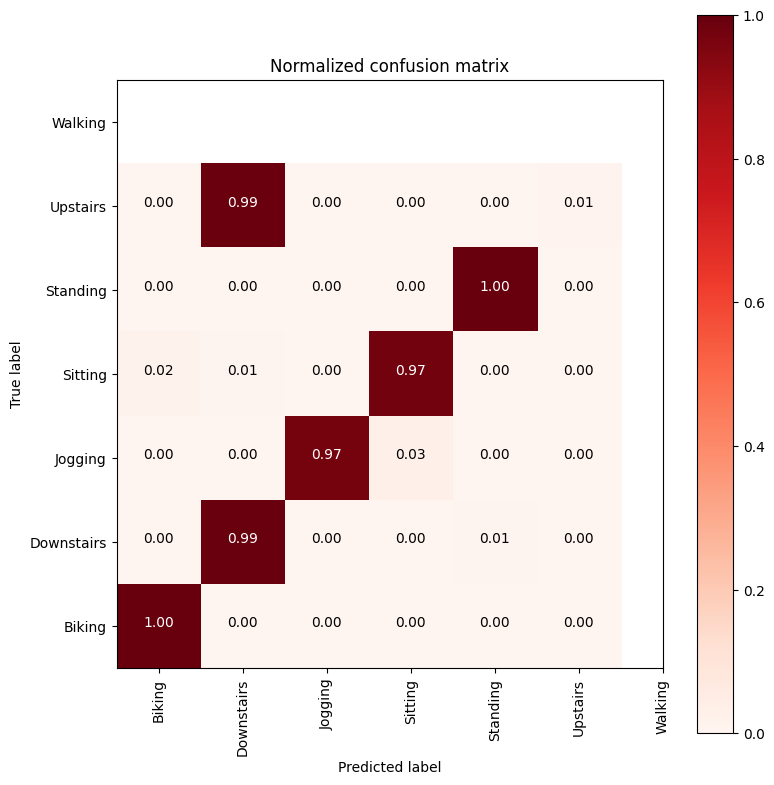

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       180
           1       0.52      0.99      0.69       189
           2       1.00      0.97      0.99       180
           3       0.99      0.97      0.98       360
           4       0.99      1.00      1.00       180
           5       1.00      0.01      0.02       171

    accuracy                           0.85      1260
   macro avg       0.91      0.83      0.78      1260
weighted avg       0.92      0.85      0.81      1260



In [20]:
cm_list_regrouped, yTest_regrouped, yPred_regrouped = LOSO_MLP_REGROUPED(best_params)

### Method for saving the yTest_regrouped and yPred_regrouped

Run the following code snippet if you wish to run the whole file.

In [21]:
os.makedirs('LOSO_MLP/test_y_pred', exist_ok=True)

with open('LOSO_MLP/test_y_pred/yTest_regrouped.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    for item in yTest_regrouped:
        writer.writerow([item])
        
with open('LOSO_MLP/test_y_pred/yPred_regrouped.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    for item in yPred_regrouped:
        writer.writerow([item])

### Method for loading yTest_regrouped and yPred_regrouped

Run the following code snippet if you want to just load the files from the folder.

In [22]:
#yTest_regrouped = []
#with open('LOSO_SVM/test_y_pred/yTest_regrouped.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yTest_regrouped.append(row[0])
#
#yPred_regrouped = []
#with open('LOSO_SVM/test_y_pred/yPred_regrouped.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yPred_regrouped.append(row[0])

### Method for printing the regrouped Confusion Matrix for all participants

If the user wishes to run the whole file, he should unpin the '#' comment line and pin as comments the '#<---#' lines.

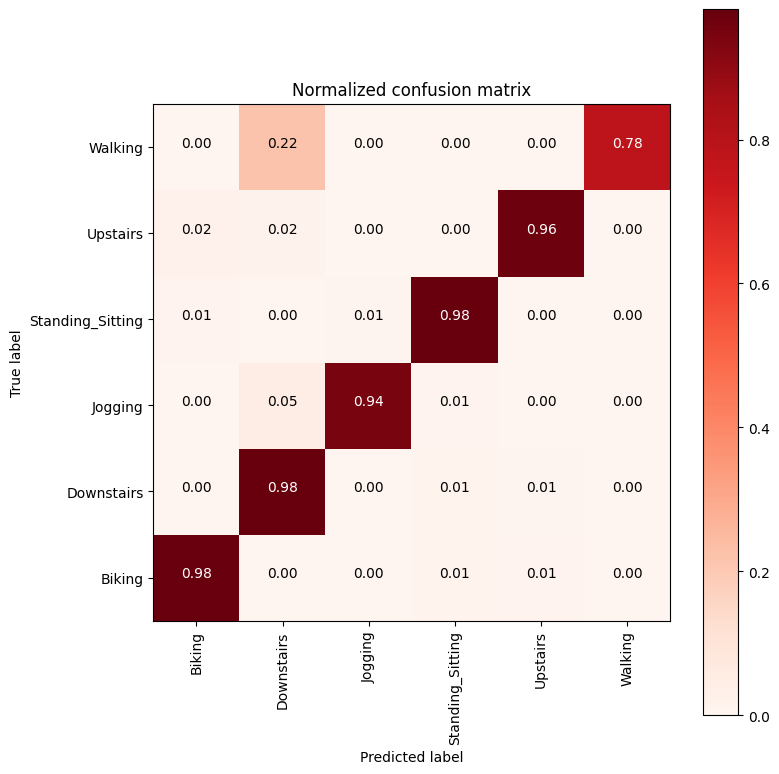

In [23]:
cm_regrouped = cm_list_regrouped[0] + cm_list_regrouped[1] + cm_list_regrouped[2] + cm_list_regrouped[3] + cm_list_regrouped[4] + cm_list_regrouped[5] + cm_list_regrouped[6] + cm_list_regrouped[7] + cm_list_regrouped[8] + cm_list_regrouped[9]

#cm_list_regrouped = []
#for i in range(10):
#    matrix = np.loadtxt('LOSO_MLP/regrouped_confusion_matrices/cm_' +str(i+1)+ '_regrouped.csv', delimiter=',').astype(np.int64)
#    cm_list_regrouped.append(matrix)
#    
#cm_regrouped = np.sum(cm_list_regrouped, axis=0)
    

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_regrouped, classes=labels2, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,5.5)
plt.show()

### Code snippet to print the Classification Report of the regrouped dataset for all participants

In [24]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr_regrouped = classification_report(yTest_regrouped, yPred_regrouped, target_names=labels2)
print(cr_regrouped)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
                  precision    recall  f1-score   support

          Biking       0.96      0.98      0.97      1800
      Downstairs       0.79      0.98      0.87      1890
         Jogging       0.99      0.94      0.97      1800
Standing_Sitting       0.98      0.98      0.98      3600
        Upstairs       0.98      0.96      0.97      1800
         Walking       0.99      0.78      0.87      1710

        accuracy                           0.95     12600
       macro avg       0.95      0.94      0.94     12600
    weighted avg       0.95      0.95      0.95     12600



### Code snippet to print the accuracy of the regrouped dataset for all participants

In [25]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(yTest_regrouped, yPred_regrouped)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.9451587301587302



In [41]:
def optimal_estimator(n):
    
    early_stopping = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
    
    train_x = pd.read_csv('10_Subject_Dataset/X_train.csv')
    train_y = pd.read_csv('10_Subject_Dataset/y_train.csv')
    
    participant_l = pd.read_csv('dataset/Left_Pocket_Dataset/Participant_' +str(n)+ '_left.csv')
    x_left = participant_l.iloc[:, :-1]
    y_left = participant_l.iloc[:, -1]
    
    participant_w = pd.read_csv('dataset/Wrist_Dataset/Participant_' +str(n)+ '_wrist.csv')
    x_wrist = participant_w.iloc[:, :-1]
    y_wrist = participant_w.iloc[:, -1]
    
    input_dim = train_x.shape[1]
    num_classes = np.unique(train_y).shape[0]
    
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    x_left = scaler.transform(x_left)
    x_wrist = scaler.transform(x_wrist)
    
    encoder = LabelEncoder()
    train_y_encoded = encoder.fit_transform(train_y)
    y_left_encoded = encoder.transform(y_left)
    y_wrist_encoded = encoder.transform(y_wrist)
    
    train_y_categorical = to_categorical(train_y_encoded, num_classes=num_classes)
    y_left_categorical = to_categorical(y_left_encoded, num_classes=num_classes)
    y_wrist_categorical = to_categorical(y_wrist_encoded, num_classes=num_classes)
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    
    model = Sequential()
    model.add(Dense(input_dim, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_x, train_y_categorical, epochs=300, batch_size=32, verbose=0,\
              callbacks=[early_stopping], validation_data=(x_left, y_left_categorical))
    y_pred_left = model.predict(x_left)
    model.fit(train_x, train_y_categorical, epochs=300, batch_size=32, verbose=0,\
              callbacks=[early_stopping], validation_data=(x_wrist, y_wrist_categorical))
    y_pred_wrist = model.predict(x_wrist)
    
    y_left_argmax = np.argmax(y_left_categorical, axis=1)
    y_wrist_argmax = np.argmax(y_left_categorical, axis=1)
    y_pred_left_argmax = np.argmax(y_pred_left, axis=1)
    y_pred_wrist_argmax = np.argmax(y_pred_wrist, axis=1)
    
    return y_pred_left_argmax, y_pred_wrist_argmax, y_left_argmax, y_wrist_argmax

In [42]:
prediction_left, prediction_wrist, y_left, y_wrist = optimal_estimator(1)

/home/paschalis/tf-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


40/40 [==============================] - 0s 1ms/step


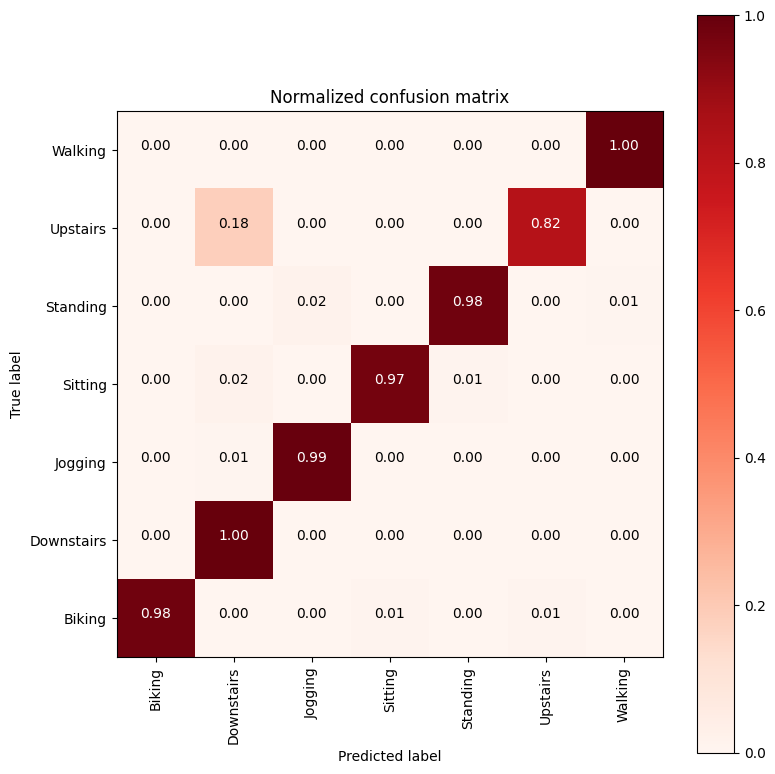

In [43]:
cm_left = confusion_matrix(y_left, prediction_left)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_left, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

In [52]:
print('-------------------------')
print('| Classification Report |')
print('-------------------------')
cr_left = classification_report(y_left, prediction_left, target_names=labels1)
print(cr_left)

-------------------------
| Classification Report |
-------------------------
              precision    recall  f1-score   support

      Biking       1.00      0.98      0.99       180
  Downstairs       0.84      1.00      0.91       189
     Jogging       0.98      0.99      0.99       180
     Sitting       0.99      0.97      0.98       180
    Standing       0.99      0.98      0.98       180
    Upstairs       0.99      0.82      0.89       180
     Walking       0.99      1.00      1.00       171

    accuracy                           0.96      1260
   macro avg       0.97      0.96      0.96      1260
weighted avg       0.97      0.96      0.96      1260



In [55]:
print('------------')
print('| Accuracy |')
print('------------')
acc_score = accuracy_score(y_left, prediction_left)
print(acc_score)

------------
| Accuracy |
------------
0.9626984126984127


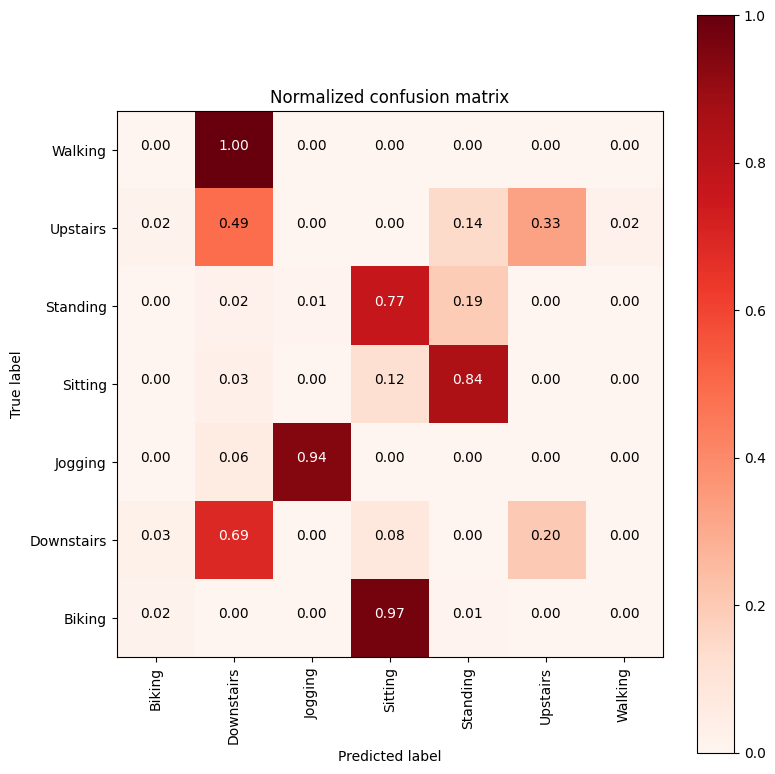

In [56]:
cm_wrist = confusion_matrix(y_wrist, prediction_wrist)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_wrist, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

In [57]:
print('-------------------------')
print('| Classification Report |')
print('-------------------------')
cr_wrist = classification_report(y_wrist, prediction_wrist, target_names=labels1)
print(cr_wrist)

-------------------------
| Classification Report |
-------------------------
              precision    recall  f1-score   support

      Biking       0.27      0.02      0.03       180
  Downstairs       0.32      0.69      0.43       189
     Jogging       0.99      0.94      0.96       180
     Sitting       0.06      0.12      0.08       180
    Standing       0.16      0.19      0.18       180
    Upstairs       0.61      0.33      0.43       180
     Walking       0.00      0.00      0.00       171

    accuracy                           0.33      1260
   macro avg       0.34      0.33      0.30      1260
weighted avg       0.35      0.33      0.31      1260



In [58]:
print('------------')
print('| Accuracy |')
print('------------')
acc_score = accuracy_score(y_wrist, prediction_wrist)
print(acc_score)

------------
| Accuracy |
------------
0.33174603174603173
